# Laboratorio 6
#### 20880 Sebastian Aristondo
#### 20293 Daniel Gonzalez

## Ejercicio 1

Cree un programa en Python (o en el lenguaje de su preferencia) para modelar la distribución de temperatura dentro
de una varilla sólida. Utilice modelado secuencial multiescala, donde combina un modelo macroscópico y un
modelo microscópico. Suponga que la varilla consta de dos materiales diferentes con diferentes conductividades
térmicas.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class atomo(object):
    
    def __init__(self, masa, left_neighbour, right_neighbour, position):
        self.move= ["left", "right"]
        self.mass = masa
        self.left_neighbour = left_neighbour
        self.right_neighbour = right_neighbour
        self.position = position

    def random_move(self):
        self.position = random.choice(self.move)
    
    def exist_colision(self):
        if self.left_neighbour:
            if self.left_neighbour.position == "right" and self.position == "left":
                return (self.left_neighbour.mass + self.mass)*0.5
        if self.right_neighbour:  
            if self.right_neighbour.position == "left" and self.position == "right":
                return (self.right_neighbour.mass + self.mass)*0.5
        
        return 0


In [3]:
masa_aluminio = 2700
masa_hierro = 7850
tipo_atomo = [masa_aluminio, masa_hierro]
c = (masa_hierro * 450 + masa_aluminio * 900) / (masa_aluminio + masa_hierro)
T = 280
iteraciones_micro = 1000
atomos = 10000
epochs = 100

In [4]:
# Definir el rango deseado para velocidades más frecuentes
velocidad_minima = 0.5
velocidad_maxima = 1.5

# Calcular la media en ese rango
media_en_rango = (velocidad_maxima + velocidad_minima) / 2

# Calcular la tasa (lambda) para la distribución exponencial
lambda_param = 1 / media_en_rango

# Tamaño de la muestra
tamaño_muestra = epochs * iteraciones_micro

# Generar una muestra de velocidades con distribución exponencial
muestras_exponencial = np.random.exponential(scale=1/lambda_param, size=tamaño_muestra)

In [5]:
varilla=[]
m = 0
for i in range(atomos):
    if i % 2 ==0:
        varilla.append(atomo(masa_aluminio, None, None, i))
        m += masa_aluminio
    else:
        varilla.append(atomo(masa_hierro, None, None, i))
        m += masa_hierro
        
for i in range(atomos):
    if i == 0:
        varilla[i].right_neighbour = varilla[i+1]
    elif i == atomos-1:
        varilla[i].left_neighbour = varilla[i-1]
    else:
        varilla[i].left_neighbour = varilla[i-1]
        varilla[i].right_neighbour = varilla[i+1]
    

In [6]:
def calculate_Q(res, velocity):
    return res * velocity

In [7]:
def temperature_differnce(Q):
    return Q / (m * c)

In [8]:
i = 0
temperatura = []
Q = []
for epoch in range(epochs):
    Q_acumulado = 0
    for iteraciones in range(iteraciones_micro):
        velocidad = muestras_exponencial[i]
        i += 1
        for atomo in varilla:
            atomo.random_move()
        for atomo in varilla:
            Q_acumulado += calculate_Q(atomo.exist_colision(), velocidad)
    Q_acumulado /= 2.0
    Q_promedio = Q_acumulado / iteraciones_micro
    T = T + temperature_differnce(Q_promedio)
    Q.append(Q_promedio)
    temperatura.append(T)


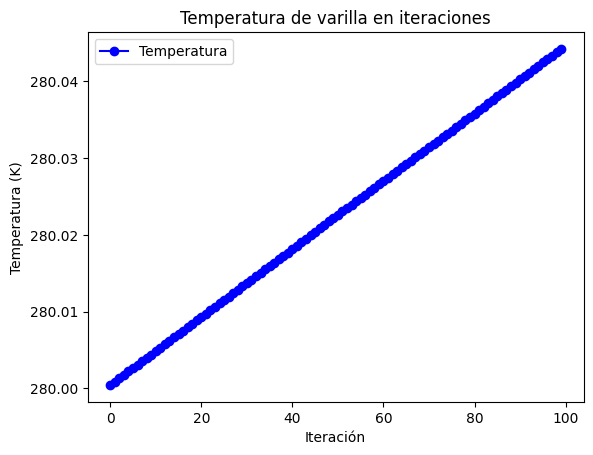

In [9]:
# Crear el gráfico con líneas que unen los puntos para 'temperatura'
plt.plot(range(len(temperatura)), temperatura, color='b', label='Temperatura', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Iteración')
plt.ylabel('Temperatura (K)')
plt.title('Temperatura de varilla en iteraciones')

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

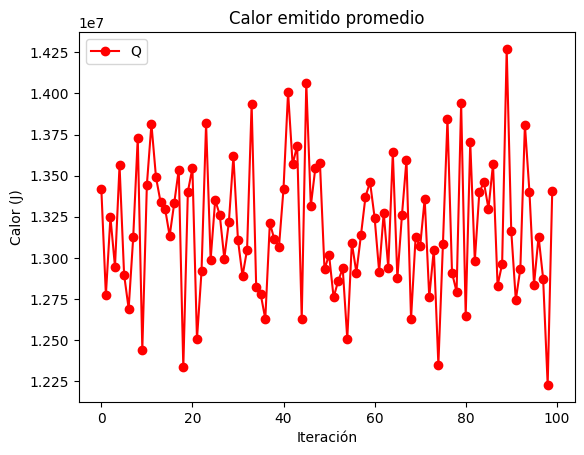

In [10]:
# Crear el gráfico con líneas que unen los puntos para 'Q'
plt.plot(range(len(Q)), Q, color='r', label='Q', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Iteración')
plt.ylabel('Calor (J)')
plt.title('Calor emitido promedio')

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

**a. ¿En qué se diferencia el modelo macroscópico del modelo microscópico en este escenario?**


El modelo macroscópico se basa en la temperatura de la varilla en general, mientras que el modelo microscópico se basa en la temperatura de los átomos que componen la varilla. También si diferencia en que el modelos microscópico se basa en agentes y el modelo macroscópico es una formula de energía cinética.

**b. ¿Cuáles son las condiciones de contorno del modelo microscópico y cómo las determina el modelo macroscópico?**


La condición del modelo microscópico se basa en si ocurre una colisión entre los átomos. Todos aquellos átomos que colisionen generar calor. El modelo macroscópico calculara la temperatura de la varilla en base a la suma de las temperaturas de los átomos.

**c. ¿Cómo adaptaría este modelo multiescala si la varilla estuviera compuesta por más de dos materiales diferentes?**


Debido a como realizamos nuestra implementación el modelo se adaptaría muy facil. Al momento de inicializar la calse atomo solo sería de establecer la masa de los n materiales nuevos. La simulación sería exactamente igual ya que solo se estaría afectando la masa de los átomos.

## Ejercicio 2

Implemente un enfoque de modelado multiescala concurrente en Python para simular el flujo de agua a través de
una formación rocosa porosa. Utilice tanto un modelo macroscópico (ley de Darcy) como un modelo microscópico
(ecuaciones de Navier-Stokes) para describir el flujo.

In [11]:
A = 1.25 # m^2
ro = 997 # kg/m^3
miu = 0.474 # Visocidad cinemática 60 C

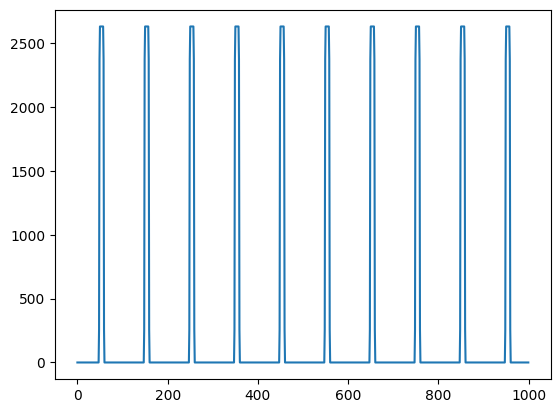

In [12]:
# Paso 1: Simulación del flujo con la Ley de Darcy (Macroescala)
def simulate_darcy_flow(velocidad_media = 0.5):
    return (ro * velocidad_media * A) / miu


# Parámetros del problema
L = 1.0  # Longitud del dominio
Nx = 100  # Número de puntos de la malla espacial
dx = L / (Nx - 1)  # Tamaño de paso en la malla
nu = 0.01  # Viscosidad cinemática
dt = 0.001  # Paso de tiempo
# Inicialización de la malla espacial
x = np.linspace(0, L, Nx)

# Inicialización de la condición inicial (perfil inicial de velocidad)
u = np.zeros(Nx)
u[int(0.5 / dx):int(0.6 / dx)] = 1.0  # Condición inicial: un pulso de velocidad


# Paso 2: Simulación del flujo con las Ecuaciones de Navier-Stokes (Microescala)
def simulate_navier_stokes_flow(macroscopic_results, u):
    u_new = np.zeros(Nx)
    for i in range(1, Nx - 1):
        # Implementación de la discretización de las ecuaciones de Navier-Stokes
        u_new[i] = u[i] + nu * dt / dx**2 * (u[i+1] - 2 * u[i] + u[i-1])

    # Actualización del perfil de velocidad
    u = u_new
    return u


velocidad_result =[] 
# Paso 3: Enfoque Multiescala Concurrente
def multiscale_simulation():
    # Inicializa las simulaciones macro y micro
    macroscopic_results = simulate_darcy_flow()
    microscopic_results = simulate_navier_stokes_flow(macroscopic_results, u)
    
    # Itera o acopla las simulaciones según sea necesario
    for _ in range(num_iterations):
        
        # Realiza la simulación microscópica
        microscopic_results = simulate_navier_stokes_flow(macroscopic_results, u)
        # Realiza la simulación macroscópica
        macroscopic_results = simulate_darcy_flow(microscopic_results)
        velocidad_result.extend(macroscopic_results)
    
    return velocidad_result

# Paso 4: Visualización del Flujo de Agua
def visualize_results(speed):
    plt.plot(speed)
    plt.show()

# Ejecuta la simulación multiescala y visualiza los resultados
num_iterations = 10
vel = multiscale_simulation()
visualize_results(vel)

Presiones en el nivel macroscópico:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]

Presiones en el nivel microscópico:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


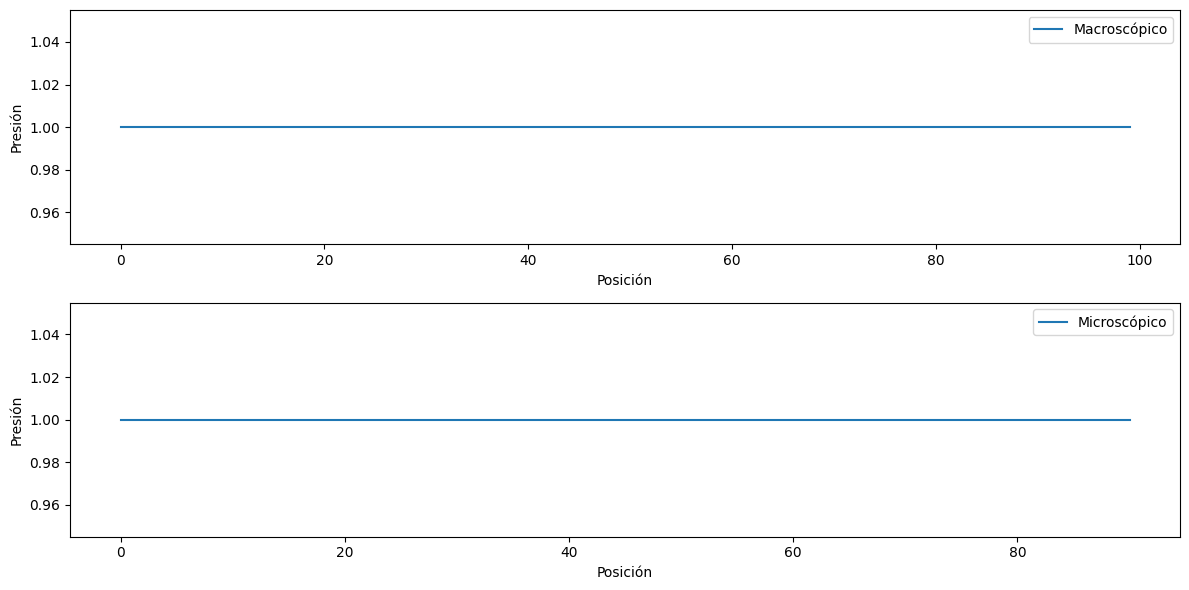

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros para la formación rocosa porosa
porosidad = 0.2  # Porosidad de la formación
permeabilidad = 1.0  # Permeabilidad de la formación

# Parámetros para la discretización
num_celdas_macro = 100  # Número de celdas para el modelo macroscópico
num_celdas_micro = 10  # Número de celdas para el modelo microscópico

# Longitud de la formación rocosa
longitud_formacion = 100.0

# Delta x para cada nivel de escala
dx_macro = longitud_formacion / num_celdas_macro
dx_micro = dx_macro * (num_celdas_macro / num_celdas_micro)

# Crear arreglos para almacenar presiones en cada celda
presiones_macro = np.ones(num_celdas_macro)  # Inicializar todas las presiones a 1.0
presiones_micro = np.ones(num_celdas_micro)  # Inicializar todas las presiones a 1.0

# Simulación en el nivel macroscópico usando la ley de Darcy
def simular_macroscopico():
    global presiones_macro
    # Aplicar la ley de Darcy: Q = -K * A * (dp/dx)
    for i in range(1, num_celdas_macro - 1):
        dp_dx = (presiones_macro[i - 1] - presiones_macro[i]) / dx_macro
        flujo = -permeabilidad * porosidad * dp_dx
        presiones_macro[i] -= flujo * dx_macro

# Simulación en el nivel microscópico usando las ecuaciones de Navier-Stokes
def simular_microscopico():
    global presiones_micro
    # Implementar las ecuaciones de Navier-Stokes para el flujo en una dimensión
    for i in range(1, num_celdas_micro - 1):
        dp_dx = (presiones_micro[i - 1] - presiones_micro[i]) / dx_micro
        flujo = -porosidad * dp_dx
        presiones_micro[i] -= flujo * dx_micro

# Función para ejecutar la simulación multiescala
def simular_multiescala(num_pasos):
    for _ in range(num_pasos):
        simular_macroscopico()  # Simular en el nivel macroscópico
        simular_microscopico()  # Simular en el nivel microscópico

# Número de pasos de simulación
num_pasos_simulacion = 100

# Ejecutar la simulación multiescala
simular_multiescala(num_pasos_simulacion)

# Imprimir resultados
print("Presiones en el nivel macroscópico:")
print(presiones_macro)

print("\nPresiones en el nivel microscópico:")
print(presiones_micro)

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, longitud_formacion, dx_macro), presiones_macro, label='Macroscópico')
plt.xlabel('Posición')
plt.ylabel('Presión')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, longitud_formacion, dx_macro * (num_celdas_macro / num_celdas_micro)), presiones_micro, label='Microscópico')
plt.xlabel('Posición')
plt.ylabel('Presión')
plt.legend()

plt.tight_layout()
plt.show()


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


C:\Users\DELL\AppData\Local\Temp\ipykernel_11564\1029233085.py:68: RuntimeWarning: invalid value encountered in scalar divide
  scaling_factor = np.mean(velocity_micro) / np.mean(velocity_macro)


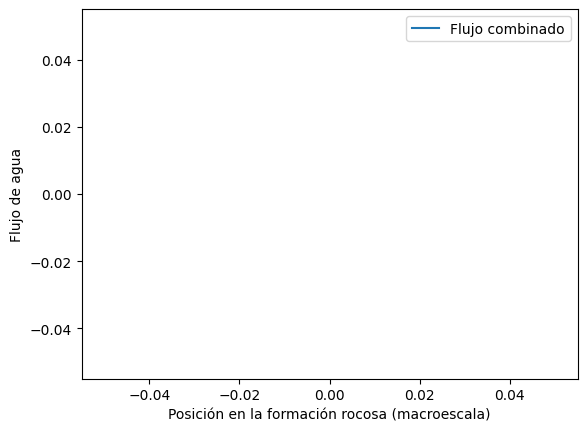

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
L = 100  # Longitud de la formación rocosa (macroescala)
Nx = 100  # Número de puntos de muestreo (macroescala)
dx = L / (Nx - 1)  # Espaciado entre puntos de muestreo (macroescala)
dt = 0.01  # Paso de tiempo
T = 5.0  # Tiempo total de simulación

# Propiedades de la formación rocosa
permeability = 1.0  # Permeabilidad de la roca (macroescala)
porosity = 0.2  # Porosidad de la roca (macroescala)

# Función para simular el flujo de agua en la macroescala usando la ley de Darcy
def simulate_darcy_flow(L, Nx, permeability, porosity, dt, T):
    # Inicializar condiciones iniciales
    pressure = np.zeros(Nx)
    velocity = np.zeros(Nx)
    
    num_steps = int(T / dt)
    
    for i in range(num_steps):
        # Aplicar la ley de Darcy para actualizar la presión y la velocidad
        velocity = -permeability * (1 / porosity) * np.gradient(pressure, dx)
        
        # Actualizar la presión considerando la variación de velocidad
        pressure += dt * (permeability / porosity) * np.gradient(velocity, dx)
        
    return velocity

# Parámetros de la simulación
L_micro = 1.0  # Longitud de la microescala
Nx_micro = 100  # Número de puntos de muestreo en la microescala
dx_micro = L_micro / (Nx_micro - 1)  # Espaciado entre puntos de muestreo en la microescala
dt_micro = 0.001  # Paso de tiempo en la microescala
T_micro = 1.0  # Tiempo total de simulación en la microescala

# Propiedades de la formación rocosa en la microescala
porosity_micro = 0.2  # Porosidad de la roca en la microescala
viscosity_micro = 1.0  # Viscosidad del fluido en la microescala

# Función para simular el flujo de agua en la microescala usando las ecuaciones de Navier-Stokes
def simulate_navier_stokes_flow(L, Nx, porosity, viscosity, dt, T):
    # Inicializar condiciones iniciales
    velocity_micro = np.zeros(Nx)
    
    num_steps = int(T / dt)
    
    for i in range(num_steps):
        # Aplicar las ecuaciones de Navier-Stokes para actualizar la velocidad
        dudt = -1.0 / (porosity * viscosity) * np.gradient(velocity_micro, dx_micro)
        velocity_micro += dt * dudt
        
    return velocity_micro

# Función para implementar el enfoque multiescala
def simulate_multiscale_flow(L_macro, Nx_macro, permeability, porosity, dt, T,
                             L_micro, Nx_micro, porosity_micro, viscosity_micro):
    # Simular flujo en macroescala (Darcy)
    velocity_macro = simulate_darcy_flow(L_macro, Nx_macro, permeability, porosity, dt, T)
    
    # Simular flujo en microescala (Navier-Stokes)
    velocity_micro = simulate_navier_stokes_flow(L_micro, Nx_micro, porosity_micro, viscosity_micro, dt, T)
    print(velocity_micro)
    # Definir la interfaz entre escalas
    # En este ejemplo simple, asumimos que la velocidad en la microescala es proporcional a la presión en la macroescala
    scaling_factor = np.mean(velocity_micro) / np.mean(velocity_macro)
    velocity_macro_interpolated = np.interp(np.linspace(0, L_macro, Nx_micro), np.linspace(0, L_macro, Nx_macro), velocity_macro)
    combined_velocity = scaling_factor * velocity_macro_interpolated + velocity_micro
    
    return combined_velocity

# Simular el flujo de agua en ambas escalas y combinarlas
combined_velocity = simulate_multiscale_flow(L, Nx, permeability, porosity, dt, T, L_micro, Nx_micro, porosity_micro, viscosity_micro)
print(combined_velocity)
# Visualizar el flujo de agua a lo largo del tiempo
x = np.linspace(0, L, Nx_micro)
plt.plot(x, combined_velocity, label='Flujo combinado')
plt.xlabel('Posición en la formación rocosa (macroescala)')
plt.ylabel('Flujo de agua')
plt.legend()
plt.show()



## Ejercicio 3

Tiene la tarea de modelar el crecimiento de la población en múltiples escalas, desde organismos individuales hasta
la población global. Para esto debe implementar un modelo multiescala en Python para analizar el crecimiento
poblacional y su impacto.

In [259]:
class packet(object):
    
    def __init__(self, mens, womens,number):
        self.number = number
        self.mens = int(mens)
        self.womens = int(womens)
        self.childrens_probability = random.uniform(0.1, 1)

    def sex(self,sobrante):
        print("Mens: ", self.mens)
        print("Womens: ", self.womens)
        cantidad_hijos = int(min(sobrante,min(self.mens, self.womens))/4 * self.childrens_probability)
        print("Childrens: ", cantidad_hijos)
        proporcion = random.uniform(0.1, 1)
        self.mens += int(cantidad_hijos * proporcion)
        self.womens += int(cantidad_hijos * (1-proporcion))
        
        
    
    def consume_resources(self):
        return int(self.mens + self.womens)

    def starvation(self,deficit):
        deficit = int(deficit)
        
        for dead in range(deficit):
            if dead %2 == 0 and self.mens > 0:
                self.mens -= 1
            elif dead %2 != 0 and self.womens > 0:
                self.womens -= 1
                
    def get_population(self):
        return int(self.mens + self.womens)

In [260]:
class village(object):
    
    def __init__(self, resources):
        self.resources = int(resources)
        self.max_resources = int(resources)
        self.regenerate = 1+random.uniform(0.5, 0.9)

    def consume_resources(self, consumtion):
        self.resources -= consumtion
    
    def regenerate_resources(self):
        if self.resources < 100:
            self.resources += 123
        self.resources *= self.regenerate
        
        if self.resources > self.max_resources:
            self.resources = self.max_resources
            
        self.resources = int(self.resources)

    def get_resources(self):
        return self.resources

    
        

In [261]:
cantidad_lugares = 5
lugares = []
poblaciones = []

for v in range(cantidad_lugares):
    lugares.append(village(random.uniform(1000, 2500)))
    if cantidad_lugares - 2 >v:
        poblaciones.append(packet(random.uniform(50, 70), random.uniform(50, 80), v))


In [262]:
dias_simulacion = 250

total_population = []
total_resources = []

acu_p = 0
acu_r = 0
for poblacion in poblaciones:
    acu_p += poblacion.get_population()
    
for lugar in lugares:
    acu_r += lugar.get_resources()
    
total_population.append(acu_p)
total_resources.append(acu_r)    


for dia in range(dias_simulacion):
    acu_p = 0
    acu_r = 0
    for poblacion in poblaciones:
        ubicacion = random.randint(0, cantidad_lugares-1)
        visited_ubicacion = lugares[ubicacion]
        resource_poblacion = poblacion.consume_resources()
        deficit = resource_poblacion - visited_ubicacion.get_resources()
        print("\n\npoblacion: ", poblacion.number)
        if deficit > 0:
            print(deficit)
            poblacion.starvation(deficit)
            visited_ubicacion.consume_resources(resource_poblacion-deficit)
        else:
            visited_ubicacion.consume_resources(resource_poblacion)
            poblacion.sex(abs(deficit))
        
        acu_p += poblacion.get_population()
        acu_r += visited_ubicacion.get_resources()
        
    total_population.append(acu_p)
    total_resources.append(acu_r)
    
    for lugar in lugares:
        lugar.regenerate_resources()
        
    

poblacion:  0
Mens:  52
Womens:  76
Childrens:  8
poblacion:  1
Mens:  60
Womens:  57
Childrens:  11
poblacion:  2
Mens:  55
Womens:  60
Childrens:  5
poblacion:  3
Mens:  65
Womens:  63
Childrens:  7
poblacion:  4
Mens:  51
Womens:  76
Childrens:  11
poblacion:  5
Mens:  57
Womens:  51
Childrens:  8
poblacion:  0
Mens:  56
Womens:  79
Childrens:  8
poblacion:  1
Mens:  62
Womens:  65
Childrens:  12
poblacion:  2
Mens:  59
Womens:  60
Childrens:  5
poblacion:  3
Mens:  68
Womens:  66
Childrens:  7
poblacion:  4
Mens:  55
Womens:  82
Childrens:  12
poblacion:  5
Mens:  58
Womens:  57
Childrens:  9
poblacion:  0
Mens:  62
Womens:  80
Childrens:  9
poblacion:  1
Mens:  63
Womens:  75
Childrens:  12
poblacion:  2
Mens:  62
Womens:  61
Childrens:  6
poblacion:  3
Mens:  71
Womens:  69
Childrens:  7
poblacion:  4
Mens:  64
Womens:  84
Childrens:  14
poblacion:  5
Mens:  61
Womens:  62
Childrens:  10
poblacion:  0
Mens:  69
Womens:  81
Childrens:  10
poblacion:  1
Mens:  73
Womens:  76
Childr

[723, 767, 814, 866, 924, 986, 1054, 1125, 1205, 1290, 1381, 1478, 1581, 1692, 1815, 1952, 2093, 2251, 2417, 2592, 2780, 2668, 2600, 2429, 2571, 2538, 2709, 1958, 1971, 2054, 2160, 2237, 2275, 2408, 2498, 2652, 2563, 2730, 2904, 2700, 2471, 1205, 1181, 814, 835, 859, 884, 910, 926, 958, 745, 770, 695, 645, 659, 676, 695, 714, 734, 756, 780, 808, 837, 866, 898, 932, 967, 1003, 1040, 1081, 1129, 1183, 1246, 1315, 1396, 1485, 1580, 1675, 1784, 1870, 1999, 2057, 1971, 2088, 2092, 578, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561,

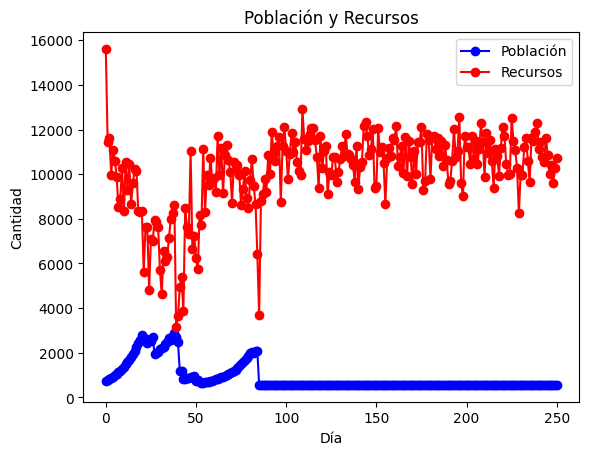

In [263]:
print(total_population)

plt.plot(range(len(total_population)), total_population, color='b', label='Población', marker='o', linestyle='-')
plt.plot(range(len(total_resources)), total_resources, color='r', label='Recursos', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Día')
plt.ylabel('Cantidad')
plt.title('Población y Recursos')
plt.legend()
plt.show()